# Azure AI Search Orchestration: A Deep Dive into Indexers, Skillsets, and Skills

Azure AI Search offers advanced search capabilities through a well-coordinated operation of **indexers**, **skillsets**, and **skills**. This hierarchical relationship ensures seamless and efficient data ingestion, enrichment, and searchability.

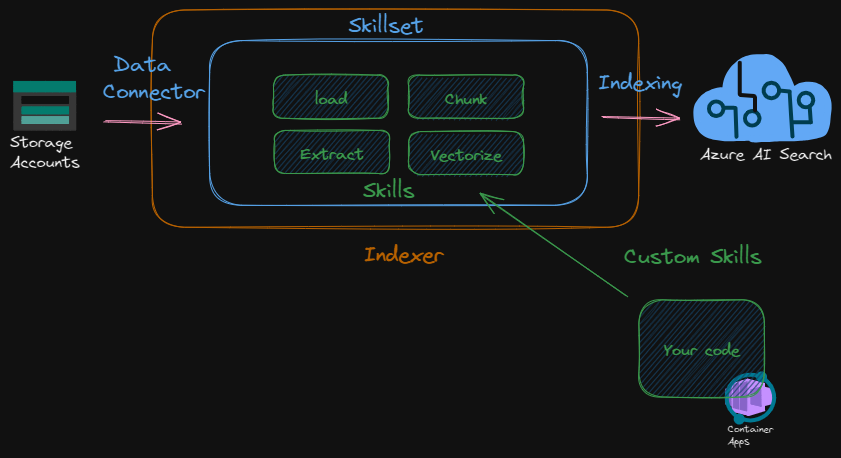

## Components of Azure AI Search Orchestration

### 1. Indexers

- **Definition:** Indexers in Azure AI Search automate the process of ingesting, transforming, and loading data from various data sources into an Azure AI search index.
- **Operation:** An indexer connects to a data source, retrieves content, and optionally applies a skillset to transform and enrich the data before loading it into a search index.
- **Supported Data Sources:** Azure Blob Storage, Azure Cosmos DB, Azure SQL Database, and others.
- **Example:** An indexer might ingest documents from Azure Blob Storage, apply a skillset for OCR and entity recognition, and then populate an Azure AI Search index with the enriched content.

### 2. Skillsets

- **Definition:** A skillset is a collection of skills that execute built-in AI or custom processing over documents retrieved from an external data source. Skillsets are reusable resources in Azure AI Search.
- **Operation:** Skills within a skillset transform the content based on the skill's function. The outputs can be text, structured data, or image descriptions.
- **Example:** A skillset might include an OCR skill for image content, a text translation skill for multilingual support, and an entity recognition skill.

### 3. Skills

- **Definition:** Skills are operations that transform content. They can be text-based for full-text search or vector-based for vector search.
- **Types:**
  - **Built-in Skills:**  These skills wrap API calls to Azure resources. They are based on pretrained models from Microsoft and can include operations like entity recognition, language detection, and sentiment analysis.
  - **Custom Skills:** Custom code executed externally to the search service, often hosted on an Azure function app. These skills extend the AI enrichment pipeline with custom processing logic.
  - **Utility Skills:** : Internal to Azure AI Search, these skills perform operations like conditional processing, document extraction, and text splitting.
- **Examples:** Text extraction, language detection, entity recognition, and optical character recognition (OCR).

For more information, please take a look at the [documentation here](https://learn.microsoft.com/en-us/azure/search/search-indexer-overview).

## 📋 Table of Contents

This notebook guides you through the following sections:

1. [**Create Index**](#create-index)
2. [**Creating DataSource**](#creating-datasource)
3. [**Adding Skills**](#adding-skills)
4. [**Creating Skillsets**](#creating-skillsets)
5. [**Creating the Indexer**](#creating-the-indexer)

In [1]:
import os

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence


In [2]:
from src.azure_search_ai.indexer import AzureIndexerManager

az_indexer_client = AzureIndexerManager()

## Create Index

In [3]:
from azure.search.documents.indexes.models import (
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    SearchField,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    HnswAlgorithmConfiguration,
    VectorSearchAlgorithmKind,
    HnswParameters,
    SearchField,
    VectorSearch,
    VectorSearchAlgorithmMetric,
    ExhaustiveKnnAlgorithmConfiguration,
    ExhaustiveKnnParameters,
    VectorSearchProfile,
    SemanticConfiguration,
    SemanticField,
    SemanticSearch,
    SemanticPrioritizedFields,
)

In [4]:
# define field types for index
images_index_fields = [
    SimpleField(
        name="id",
        type=SearchFieldDataType.String,
        key=True,
        sortable=True,
        filterable=True,
        facetable=True,
    ),
    SimpleField(name="url", type=SearchFieldDataType.String),
    SimpleField(name="categoryEnriched", type=SearchFieldDataType.String),
    SearchableField(name="title", type=SearchFieldDataType.String),
    SearchableField(name="summary", type=SearchFieldDataType.String),
    SearchField(
        name="summaryVector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        vector_search_dimensions=1536,
        vector_search_profile_name="myHnswProfile",
    ),
]

# Configure the vector search configuration
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw",
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(
                m=5,
                ef_construction=300,
                ef_search=400,
                metric=VectorSearchAlgorithmMetric.COSINE,
            ),
        ),
        ExhaustiveKnnAlgorithmConfiguration(
            name="myExhaustiveKnn",
            kind=VectorSearchAlgorithmKind.EXHAUSTIVE_KNN,
            parameters=ExhaustiveKnnParameters(
                metric=VectorSearchAlgorithmMetric.COSINE
            ),
        ),
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw",
        ),
        VectorSearchProfile(
            name="myExhaustiveKnnProfile",
            algorithm_configuration_name="myExhaustiveKnn",
        ),
    ],
)

semantic_config_images = SemanticConfiguration(
    name="index-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        title_field=SemanticField(field_name="title"),
        keywords_fields=[SemanticField(field_name="categoryEnriched")],
        content_fields=[SemanticField(field_name="summary")],
    ),
)
# Create the semantic settings with the configuration
semantic_search = SemanticSearch(configurations=[semantic_config_images])

In [5]:
az_indexer_client.create_index(
    index_name="test-skillset-index",
    fields=images_index_fields,
    vector_search=vector_search,
    semantic_search=semantic_search,
)

2024-01-30 19:09:06,309 - micro - MainProcess - INFO     Index test-skillset-index created (core.py:create_index:134)


## Creating DataSource

In [6]:
az_indexer_client.create_data_source_connection(
    name="ocr-pdf-blob-datasource",
    description="""Data source for OCR images extracted from PDFs 
                                                for multimodal search purposes""",
    container_name="customskillspdf",
    type="azureblob",
)

2024-01-30 19:09:09,122 - micro - MainProcess - INFO     Data source 'ocr-pdf-blob-datasource' created or updated (core.py:create_data_source_connection:166)


## Adding Skills 

In [21]:
inputs = [{"name": "text", "source": "/document/description"}]

outputs = [{"name": "embedding", "targetName": "vector"}]

In [22]:
az_indexer_client.add_built_in_skill(
    odata_type="EmbeddingSkill",
    name="image-ocr-embedding-skill",
    description="Vectorize summaries extracted from images using ada",
    context="/document",
    inputs=inputs,
    outputs=outputs,
)

## Creating skillsets 

In [23]:
az_indexer_client.create_skillset(
    name="pdf-embedding-skillset-test",
    description="Skillset to generate embeddings for images using Azure OpenAI",
)

2024-01-30 19:12:27,699 - micro - MainProcess - INFO     Skillset: 
{
    "name": "pdf-embedding-skillset-test",
    "description": "Skillset to generate embeddings for images using Azure OpenAI",
    "skills": [
        {
            "@odata.type": "#Microsoft.Skills.Text.AzureOpenAIEmbeddingSkill",
            "name": "image-ocr-embedding-skill",
            "description": "Vectorize summaries extracted from images using ada",
            "context": "/document",
            "resourceUri": "https://ml-workspace-dev-canadaeast-001-aoai.openai.azure.com",
            "apiKey": "fa4384cb235b4b4781ee2af4c997f37b",
            "deploymentId": "foundational-canadaeast-ada",
            "inputs": [
                {
                    "name": "text",
                    "source": "/document/description"
                }
            ],
            "outputs": [
                {
                    "name": "embedding",
                    "targetName": "vector"
                }
            

## Creating the Indexer

In Azure AI Search, the indexer is a crucial component that carries out the heavy lifting. It operates by ingesting data from your data source and processing it to make it searchable.

In [24]:
parameters = {
    "maxFailedItems": 0,  # The maximum number of items that can fail before the indexer is considered to have failed
    "maxFailedItemsPerBatch": 0,  # The maximum number of items that can fail in a batch before the batch is considered to have failed
    "configuration": {
        "dataToExtract": "allMetadata",  # The type of data to extract from the source
        "parsingMode": "default",  # The parsing mode to use
        "indexedFileNameExtensions": ".pdf",  # The file extensions to index
    },
}

In [25]:
field_mappings = [  # The mappings from source fields to target fields
    {
        "sourceFieldName": "metadata_storage_path",  # The source field
        "targetFieldName": "path",  # The target field
        "mappingFunction": {
            "name": "base64Encode"  # The function to use to map the source field to the target field
        },
    },
    {"sourceFieldName": "metadata_storage_name", "targetFieldName": "name"},
    {"sourceFieldName": "metadata_storage_path", "targetFieldName": "url"},
]

In [26]:
output_field_mappings = [  # The mappings from output fields to target fields
    {"sourceFieldName": "/document/textVector", "targetFieldName": "textVector"},
    {"sourceFieldName": "/document/imageVector", "targetFieldName": "imageVector"},
    {"sourceFieldName": "/document/description", "targetFieldName": "description"},
]

In [27]:
az_indexer_client.create_indexer(
    indexer_name="testindexer",
    description="indexingtest",
    data_source_name="ocr-image-blob-datasource",
    skillset_name="test12345",
    target_index_name="image-ocr-index",
    parameters=parameters,
    field_mappings=field_mappings,
    output_field_mappings=output_field_mappings,
)

: 

## Custom Skill

In [8]:
az_indexer_client.add_custom_skill(
    name="ocr-pdf-skill",
    description="""Custom skill to extract text from PDFs""",
    uri="",  # <--- Add the URI of the skill
    context="document",
    inputs=inputs,
    outputs=outputs,
)